In [2]:
from fastai.imports import *
import torch
from tqdm import *

In [3]:
torch.cuda.get_device_properties(0)

# torch.cuda.current_device()

_CudaDeviceProperties(name='Tesla K80', major=3, minor=7, total_memory=11441MB, multi_processor_count=13)

In [4]:
PATH = Path('data/lsun')
IMG_PATH = PATH/'bedroom'
CSV_PATH = PATH/'files.csv'
TMP_PATH = PATH/'tmp'
TMP_PATH.mkdir(exist_ok=True)

In [5]:
# create files_sample.csv
files = PATH.glob('bedroom/**/*.jpg')

with CSV_PATH.open('w') as foo:
    for f in files:
        foo.write(f'{f.relative_to(IMG_PATH)},0\n')

CSV_PATH = PATH/'files_sample.csv'
files = PATH.glob('bedroom/**/*.jpg')

with CSV_PATH.open('w') as foo:
    for f in files:
        if random.random() < 0.1:
            foo.write(f'{f.relative_to(IMG_PATH)},0\n')

In [6]:
def conv_layer(ni, nf, ks=3, stride=1, bn=True, pad=None):
    
    if pad is None:
        pad = ks//2//stride
    
    if bn == False:
        return nn.Sequential(
            nn.Conv2d(in_channels=ni, out_channels=nf, kernel_size=ks, bias=False, stride=stride, padding=pad), 
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )
    return nn.Sequential(
            nn.Conv2d(in_channels=ni, out_channels=nf, kernel_size=ks, bias=False, stride=stride, padding=pad),
            nn.BatchNorm2d(num_features=nf), 
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )



In [7]:
class DCGAN_Discriminator(nn.Module):
    def __init__(self, isize, ni, nf, n_extra_layers=0):
        super().__init__()
        assert isize % 16 == 0, 'isize must be a multiple of 16'
        
        # intial layer wiht stride 2 and follow up layers if needed
        print(f'ni: {ni}')
        print(f'nf: {nf}')
        self.initial = conv_layer(ni, nf, ks=4, bn=False, stride=2)
        csize = int(isize / 2)
        cnf = nf
        # a bit ugly
        self.extra = []
        self.extra = self.extra + [conv_layer(cnf, cnf, ks=4, stride=1) for t in range(n_extra_layers)]
        self.extra = nn.Sequential(*self.extra)
        
        # until size > 4 create smaller layers aka a pyramide :P
        pyr_layers = []
        while csize > 4:
            pyr_layers.append(conv_layer(cnf, cnf*2, ks=4, stride=2))
            cnf = cnf * 2
            csize = csize / 2
        self.pyramid = nn.Sequential(*pyr_layers)
        
        # Final layer with kernal size of 4 and one output channel (1x4)
        self.final = nn.Conv2d(cnf, 1, 4, stride=1, padding=0, bias=False)
        
    def forward(self, input):
        x = self.initial(input)
        x = self.extra(x)
        x = self.pyramid(x)
        x = self.final(x)
        return x.mean(0).view(1)

In [8]:
def decon_layer(ni, nf, ks=3, stride=1, pad=None):
    return nn.Sequential(
        nn.ConvTranspose2d(ni, nf, ks, stride, padding=pad, bias=False),
        nn.BatchNorm2d(nf),
        nn.LeakyReLU(inplace=True)
    )

In [9]:
class DCGAN_Generator(nn.Module):
    def __init__(self, isize, nz, ni, nf, n_extra_layers=0):
        super().__init__()
        assert isize % 16 == 0, 'isize has to be a multiple of 16'
        
        cnf = int(nf // 2)
        tisize = int(nf // 4)
        while tisize != isize:
            cnf = int(cnf * 2)
            tisize = int(tisize * 2)
        layers = [decon_layer(nz, cnf, 4, 1, 0)]
        
        csize = 4
        while csize < isize//2:
            layers.append(decon_layer(cnf, cnf//2, 4, 2, 1))
            cnf = cnf // 2
            csize = csize * 2
            
        layers = layers + [decon_layer(cnf, cnf, 3, 1, 1) for t in range(n_extra_layers)]
        layers.append(nn.ConvTranspose2d(cnf, ni, 4, 2, 1, bias=False))
        self.features = nn.Sequential(*layers)
        
    def forward(self, input):
        return torch.tanh(self.features(input))

In [10]:
class DCGAN_D(nn.Module):
    def __init__(self, isize, nc, ndf, n_extra_layers=0):
        super().__init__()
        assert isize % 16 == 0, "isize has to be a multiple of 16"

        self.initial = ConvBlock(nc, ndf, 4, 2, bn=False)
        csize,cndf = isize/2,ndf
        self.extra = nn.Sequential(*[ConvBlock(cndf, cndf, 3, 1)
                                    for t in range(n_extra_layers)])

        pyr_layers = []
        while csize > 4:
            pyr_layers.append(ConvBlock(cndf, cndf*2, 4, 2))
            cndf *= 2; csize /= 2
        self.pyramid = nn.Sequential(*pyr_layers)
        
        self.final = nn.Conv2d(cndf, 1, 4, padding=0, bias=False)

    def forward(self, input):
        x = self.initial(input)
        x = self.extra(x)
        x = self.pyramid(x)
        return self.final(x).mean(0).view(1)

In [11]:
class ConvBlock(nn.Module):
    def __init__(self, ni, no, ks, stride, bn=True, pad=None):
        super().__init__()
        if pad is None: pad = ks//2//stride
        self.conv = nn.Conv2d(ni, no, ks, stride, padding=pad, bias=False)
        self.bn = nn.BatchNorm2d(no) if bn else None
        self.relu = nn.LeakyReLU(0.2, inplace=True)
    
    def forward(self, x):
        x = self.relu(self.conv(x))
        return self.bn(x) if self.bn else x

In [12]:
bs, nz, = 64, 100

In [13]:
from fastai import *
from fastai.vision import *

In [14]:
tfms = get_transforms()
# md = ImageDataBunch.from_csv(PATH/'bedroom', 
#                              label_col=False, 
#                              csv_labels='files_sample.csv',
#                              bs=128, no_check=True,
#                              ds_tfms=tfms)


sz = 64 # our initial size will be 64*64
data = (ImageItemList.from_csv(PATH/'bedroom', 'files_sample.csv')
        .random_split_by_pct(0.2) # will split our data for us (train/valid) 20% of it will go into valid
        .label_from_df(sep=' ')
        .transform(tfms, size=sz)
        .databunch().normalize(imagenet_stats)) 

In [15]:
x,_ = next(iter(data.valid_dl))
x.shape

torch.Size([64, 3, 64, 64])

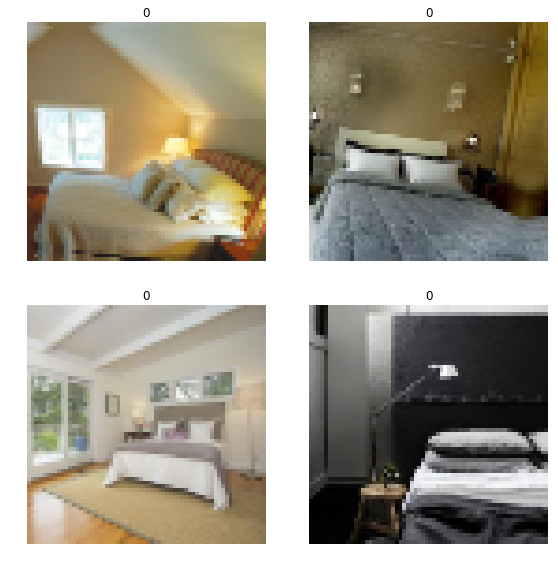

In [16]:
data.show_batch(rows=2)

In [18]:
netG = DCGAN_Generator(isize=sz, nz=nz, ni=3, nf=sz, n_extra_layers=1).cuda()
# netD = DCGAN_Discriminator(sz, 3, sz, 1).cuda()
# netD = DCGAN_D(sz, 3, sz, n_extra_layers=1).cuda()

In [20]:
netG

DCGAN_Generator(
  (features): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace)
    )
    (1): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace)
    )
    (2): Sequential(
      (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace)
    )
    (3): Sequential(
      (0): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.

In [20]:
# check if models are on cuda
print(next(netG.parameters()).is_cuda)
print(next(netD.parameters()).is_cuda)

True
True


In [21]:
from torchsummary import summary
from torchvision import models

In [22]:
# summary(netD, (64,4, 4))

In [23]:
from torch.autograd import Variable

def create_variable(x, volatile, requires_grad=False):
    if not isinstance(x, Variable):
        x = Variable(T(x), volatile=volatile, requires_grad=requires_grad)
    return x

def V_(x, requires_grad=False, volatile=False):
    return create_variable(x, volatile=volatile, requires_grad=requires_grad)
def V(x, requires_grad=False, volatile=False):
    return [V_(o, requires_grad=requires_grad, volatile=volatile)
            for o in x] if isinstance(x,(list,tuple)) else V_(x, requires_grad=requires_grad, volatile=volatile)

In [24]:
def create_noise(b): return V(torch.zeros(b, nz, 1, 1).normal_(0, 1)).cuda()

In [25]:
# preds = netG(create_noise(4))
# pred_ims = data.denorm(preds)

# fig, axes = plt.subplots(2, 2, figsize=(6, 6))
# for i,ax in enumerate(axes.flat): ax.imshow(pred_ims[i])
# plt.imshow(pred_ims[0][0])

In [26]:
optimizerD = optim.SGD(netD.parameters(), lr = 1e-4)
optimizerG = optim.Adam(netG.parameters(), lr = 1e-4)

In [36]:
def set_trainable_attr(m,b):
    m.trainable=b
    for p in m.parameters(): p.requires_grad=b

def set_trainable(l, b):
    apply_leaf(l, lambda m: set_trainable_attr(m,b))

In [37]:
def train(niter, first=True):
    gen_iterations = 0
    for epoch in range(niter):
        netD.train()
        netG.train()
        data_iter = iter(data.train_dl)
        i = 0
        n = len(data.train_dl)
        
        with tqdm(total=n) as pbar:
            while i < n:
                set_trainable(netD, True)
                set_trainable(netG, False)

                d_iters = 100 if (first and (gen_iterations < 25) or (gen_iterations % 500 == 0)) else 5
                j = 0
                
                while (j < d_iters) and (i < n):
                    j += 1; i += 1
                    for p in netD.parameters(): p.data.clamp_(-0.01, 0.01)
                    
                    real = V(next(data_iter)[0])
                    real_loss = netD(real)
                    
                    fake = netG(create_noise(real.size(0)))
                    fake_loss = netD(V(fake.data))
                    
                    netD.zero_grad()
                    lossD = real_loss-fake_loss
                    lossD.backward()
                    optimizerD.step()
                    pbar.update()

                set_trainable(netD, False)
                set_trainable(netG, True)
                netG.zero_grad()
                lossG = netD(netG(create_noise(bs))).mean(0).view(1)
                lossG.backward()
                optimizerG.step()
                gen_iterations += 1
            
        print(f'Loss_D {to_np(lossD)}; Loss_G {to_np(lossG)}; '
              f'D_real {to_np(real_loss)}; Loss_D_fake {to_np(fake_loss)}')

In [38]:
train(1, True)

100%|██████████| 381/381 [04:01<00:00,  5.10it/s]


Loss_D [-0.000286]; Loss_G [-0.000222]; D_real [-0.000462]; Loss_D_fake [-0.000177]


In [ ]:
train(600, False)

  0%|          | 0/381 [00:00<?, ?it/s]

Loss_D [0.00048]; Loss_G [-0.000564]; D_real [-8.312961e-05]; Loss_D_fake [-0.000563]


  0%|          | 0/381 [00:00<?, ?it/s]

Loss_D [0.000447]; Loss_G [-0.00053]; D_real [-7.924755e-05]; Loss_D_fake [-0.000526]


  0%|          | 0/381 [00:00<?, ?it/s]

Loss_D [0.00043]; Loss_G [-0.000499]; D_real [-7.249301e-05]; Loss_D_fake [-0.000502]


  0%|          | 0/381 [00:00<?, ?it/s]

Loss_D [0.00041]; Loss_G [-0.000467]; D_real [-5.900943e-05]; Loss_D_fake [-0.000469]


  0%|          | 0/381 [00:00<?, ?it/s]

Loss_D [0.000391]; Loss_G [-0.000445]; D_real [-5.714678e-05]; Loss_D_fake [-0.000448]


  0%|          | 0/381 [00:00<?, ?it/s]

Loss_D [0.000373]; Loss_G [-0.00043]; D_real [-5.934068e-05]; Loss_D_fake [-0.000432]


  0%|          | 0/381 [00:00<?, ?it/s]

Loss_D [0.000335]; Loss_G [-0.000406]; D_real [-7.061941e-05]; Loss_D_fake [-0.000405]


  0%|          | 0/381 [00:00<?, ?it/s]

Loss_D [0.000324]; Loss_G [-0.000393]; D_real [-6.820865e-05]; Loss_D_fake [-0.000392]


  0%|          | 0/381 [00:00<?, ?it/s]

Loss_D [0.000304]; Loss_G [-0.000377]; D_real [-7.229186e-05]; Loss_D_fake [-0.000376]


  0%|          | 0/381 [00:00<?, ?it/s]

Loss_D [0.00029]; Loss_G [-0.000358]; D_real [-6.832551e-05]; Loss_D_fake [-0.000359]


  0%|          | 0/381 [00:00<?, ?it/s]

Loss_D [0.000276]; Loss_G [-0.000339]; D_real [-6.133667e-05]; Loss_D_fake [-0.000338]


  0%|          | 0/381 [00:00<?, ?it/s]

Loss_D [0.000264]; Loss_G [-0.000323]; D_real [-5.844811e-05]; Loss_D_fake [-0.000322]


  0%|          | 0/381 [00:00<?, ?it/s]

Loss_D [0.000249]; Loss_G [-0.000306]; D_real [-5.697667e-05]; Loss_D_fake [-0.000306]


  0%|          | 0/381 [00:00<?, ?it/s]

Loss_D [0.000229]; Loss_G [-0.000291]; D_real [-6.1422e-05]; Loss_D_fake [-0.00029]


  0%|          | 0/381 [00:00<?, ?it/s]

Loss_D [0.000218]; Loss_G [-0.000277]; D_real [-6.021987e-05]; Loss_D_fake [-0.000278]


  0%|          | 0/381 [00:00<?, ?it/s]

Loss_D [0.000206]; Loss_G [-0.000266]; D_real [-5.940438e-05]; Loss_D_fake [-0.000266]


  0%|          | 0/381 [00:00<?, ?it/s]

Loss_D [0.000194]; Loss_G [-0.000254]; D_real [-6.035698e-05]; Loss_D_fake [-0.000254]


  0%|          | 0/381 [00:00<?, ?it/s]

Loss_D [5.103721e-05]; Loss_G [-0.000106]; D_real [-5.485884e-05]; Loss_D_fake [-0.000106]


  0%|          | 0/381 [00:00<?, ?it/s]

Loss_D [4.898747e-05]; Loss_G [-0.000104]; D_real [-5.473357e-05]; Loss_D_fake [-0.000104]


  0%|          | 0/381 [00:00<?, ?it/s]

Loss_D [4.651296e-05]; Loss_G [-0.000102]; D_real [-5.498292e-05]; Loss_D_fake [-0.000101]


  0%|          | 0/381 [00:00<?, ?it/s]

Loss_D [4.514965e-05]; Loss_G [-9.956313e-05]; D_real [-5.43444e-05]; Loss_D_fake [-9.949404e-05]


  0%|          | 0/381 [00:00<?, ?it/s]

Loss_D [-4.712929e-07]; Loss_G [-5.409624e-05]; D_real [-5.457672e-05]; Loss_D_fake [-5.410543e-05]


  0%|          | 0/381 [00:00<?, ?it/s]

Loss_D [-2.701199e-07]; Loss_G [-5.427573e-05]; D_real [-5.452542e-05]; Loss_D_fake [-5.42553e-05]


 13%|█▎        | 51/381 [00:08<00:57,  5.70it/s]

In [ ]:
pba

In [40]:
def gallery(x, nc=3):
    n,h,w,c = x.shape
    nr = n//nc
    assert n == nr*nc
    return (x.reshape(nr, nc, h, w, c)
              .swapaxes(1,2)
              .reshape(h*nr, w*nc, c))

In [57]:
fixed_noise = create_noise(bs)
netD.eval()
netG.eval()
fake = netG(fixed_noise).data.cpu()
faked = np.clip(data.denorm(fake),0,1)

plt.figure(figsize=(9,9))
# plt.imshow(gallery(faked, 8));


<Figure size 648x648 with 0 Axes>

<Figure size 648x648 with 0 Axes>

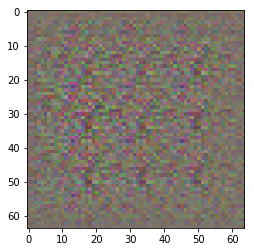

In [58]:
rolled = np.rollaxis(np.array(faked[0]), 0, 3)
rolled.shape
plt.imshow(rolled)
# plt.imshow(faked[0].shape)